In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/perturbench/0_datasets")
print(os.getcwd())

import sys
sys.path.append(os.path.abspath('..'))

/gpfs/group/jin/asun/perturbench/0_datasets


In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [3]:
boli = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/raw_data/boli_ctx_scprocess_no+ctrl.h5ad')
boli

AnnData object with n_obs × n_vars = 21700 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'Assign', 'scds', 'cxds', 'bcds', 'Sample', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score', 'predicted.subclass', 'CT', 'mito', 'BioSamp', 'CT2', 'ForPlot', 'Remove', 'active_ident', 'Assign_clean', 'condition', 'cell_type', 'cell_class'
    var: 'variable_gene', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [4]:

# start with default "train"
boli.obs["transfer_split_seed1"] = "train"

# condition = TBR1 or SATB2  AND  cell_type = L6_CT_CTX → "test"
mask_test = (
    boli.obs["condition"].isin(["TBR1", "SATB2"])
    & (boli.obs["cell_type"] == "L6_CT_CTX")
)
boli.obs.loc[mask_test, "transfer_split_seed1"] = "test"

# condition = XPO7  AND  cell_type = L6_CT_CTX → "val"
mask_val = (
    (boli.obs["condition"] == "XPO7")
    & (boli.obs["cell_type"] == "L6_CT_CTX")
)
boli.obs.loc[mask_val, "transfer_split_seed1"] = "val"

In [10]:
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

ctrl_label = "ctrl"                 # change if your control label is different
split_col  = "transfer_split_seed1"

# Make sure the split column exists (you already set defaults above)
if split_col not in boli.obs:
    boli.obs[split_col] = "train"

# Work per cell type, only among control cells
for ct in boli.obs.loc[boli.obs["condition"] == ctrl_label, "cell_type"].unique():
    # indices (row labels) of ctrl cells for this cell type
    idx = boli.obs.index[
        (boli.obs["condition"] == ctrl_label) & (boli.obs["cell_type"] == ct)
    ].to_numpy()

    # randomize order (without replacement)
    rng.shuffle(idx)

    n = idx.size
    # split points for ~50% / 25% / 25%
    p1 = int(np.floor(0.50 * n))
    p2 = int(np.floor(0.75 * n))

    train_idx = idx[:p1]
    val_idx   = idx[p1:p2]
    test_idx  = idx[p2:]

    # assign splits
    boli.obs.loc[train_idx, split_col] = "train"
    boli.obs.loc[val_idx,   split_col] = "val"
    boli.obs.loc[test_idx,  split_col] = "test"

# (optional) make the column categorical for consistency
boli.obs[split_col] = boli.obs[split_col].astype("category")

In [ ]:
# Save CSV with transfer split information
out = boli.obs[["transfer_split_seed1"]].copy()
csv_filename = f"linear_baseline_split_ctrls.csv"
out.to_csv(csv_filename, index=True, index_label="cell_barcode", header=False)

# Boli STATE

In [3]:
import warnings

# Suppress the specific warning
warnings.filterwarnings('ignore', category=FutureWarning)

boli_state = sc.read_h5ad("/gpfs/group/jin/skim/STATE/state/test_boli_NTsubset/processed_data/Boli_Perturb_CTX_edit_NTsubset_hvg.h5ad")

In [4]:
boli_state

AnnData object with n_obs × n_vars = 33038 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'Assign', 'scds', 'cxds', 'bcds', 'Sample', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score', 'predicted.subclass', 'CT', 'mito', 'BioSamp', 'CT2', 'ForPlot', 'Remove', 'active_ident', 'Assign_edit'
    var: 'variable_gene', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_hvg'
    layers: 'counts'

In [6]:
test = boli_state[:, boli_state.var["highly_variable"]]

In [7]:
test

View of AnnData object with n_obs × n_vars = 33038 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'Assign', 'scds', 'cxds', 'bcds', 'Sample', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score', 'predicted.subclass', 'CT', 'mito', 'BioSamp', 'CT2', 'ForPlot', 'Remove', 'active_ident', 'Assign_edit'
    var: 'variable_gene', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_hvg'
    layers: 'counts'

In [13]:
test.obs["predicted.subclass"].value_counts()

predicted.subclass
L6 CT CTX        7860
L4-5 IT CTX      3761
L5 PT CTX        3710
L2-3 IT CTX-1    3122
L5 NP CTX        2755
L6 IT CTX        2544
L5 IT CTX        1939
CT SUB           1689
Pvalb            1317
L2-3 IT CTX-2    1120
Sst               838
NP SUB            468
L3 RSP-ACA        370
L6b CTX           367
L2-3 IT PPP       356
L5 IT TPE-ENT     172
L5 PPP            155
Vip               116
Lamp5             111
Oligo              52
Sncg               51
SUB-ProS           33
Car3               30
Astro              29
NP PPP             26
CR                 14
Micro-PVM           9
L2 IT RHP           7
Endo                6
SMC-Peri            5
VLMC                2
L2 IT ENTl          1
L6 IT ENTl          1
L6b-CT ENT          1
V3d                 1
Name: count, dtype: int64

In [23]:
# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print the full groupby result
print(test.obs.groupby(["predicted.subclass", "Assign_edit"]).size())

# Optional: Reset display options after printing
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

predicted.subclass  Assign_edit
Astro               Ank3              5
                    Bcl11b            3
                    Ctrl              4
                    Cul1              0
                    Cx3cl1            1
                    Dab1              2
                    Herc1             1
                    Rb1cc1            1
                    Satb2             5
                    Tbr1              3
                    Trio              2
                    Xpo7              2
CR                  Ank3              1
                    Bcl11b            2
                    Ctrl              0
                    Cul1              3
                    Cx3cl1            0
                    Dab1              1
                    Herc1             0
                    Rb1cc1            2
                    Satb2             0
                    Tbr1              3
                    Trio              2
                    Xpo7              0
CT SUB  

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_counts(df, cell_line_col="cell_line", gene_col="gene", seed_col="transfer_split_seed1"):
    """
    Make heatmaps of counts per (cell_line, gene) × seed from a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with at least [cell_line_col, gene_col, seed_col].
    cell_line_col : str, default "cell_line"
        Column containing cell line identifiers.
    gene_col : str, default "gene"
        Column containing gene identifiers.
    seed_col : str, default "transfer_split_seed1"
        Column containing split/seed values.

    Returns
    -------
    fig : matplotlib.figure.Figure
    axes : np.ndarray of Axes
    """
    # counts
    count_long = (
        df.groupby([gene_col, seed_col, cell_line_col])
        .size()
        .reset_index(name="count")
    )

    # pivot to wide format
    cell_counts_all = count_long.pivot(
        index=[cell_line_col, gene_col],
        columns=seed_col,
        values="count"
    ).reset_index()

    cell_counts_all.columns.name = ""

    # drop rows with all NaN counts
    filtered = cell_counts_all.dropna(
        axis=0,
        how="all",
        subset=cell_counts_all.columns[2:]
    )

    cell_classes = filtered[cell_line_col].unique()
    n_cols = 2
    n_rows = (len(cell_classes) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, cell_class in enumerate(cell_classes):
        ax = axes[i]
        subset = (
            filtered[filtered[cell_line_col] == cell_class]
            .set_index(gene_col)
            .drop(columns=cell_line_col)
            .fillna(0)
        )
        data = subset.values

        im = ax.imshow(data, aspect="auto", cmap="viridis")
        ax.set_title(str(cell_class))
        ax.set_xticks(np.arange(subset.shape[1]))
        ax.set_xticklabels(subset.columns, rotation=45, ha="right")
        ax.set_yticks(np.arange(subset.shape[0]))
        ax.set_yticklabels(subset.index)

        # annotate each cell
        for y in range(data.shape[0]):
            for x in range(data.shape[1]):
                value = data[y, x]
                ax.text(
                    x, y, int(value),
                    ha="center", va="center",
                    color="white" if value < data.max() / 2 else "black",
                    fontsize=8
                )

        fig.colorbar(im, ax=ax, shrink=0.6)

    # delete unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    return fig, axes

In [7]:
out

NameError: name 'out' is not defined

/tmp/ipykernel_30212/1491118139.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([gene_col, seed_col, cell_line_col])


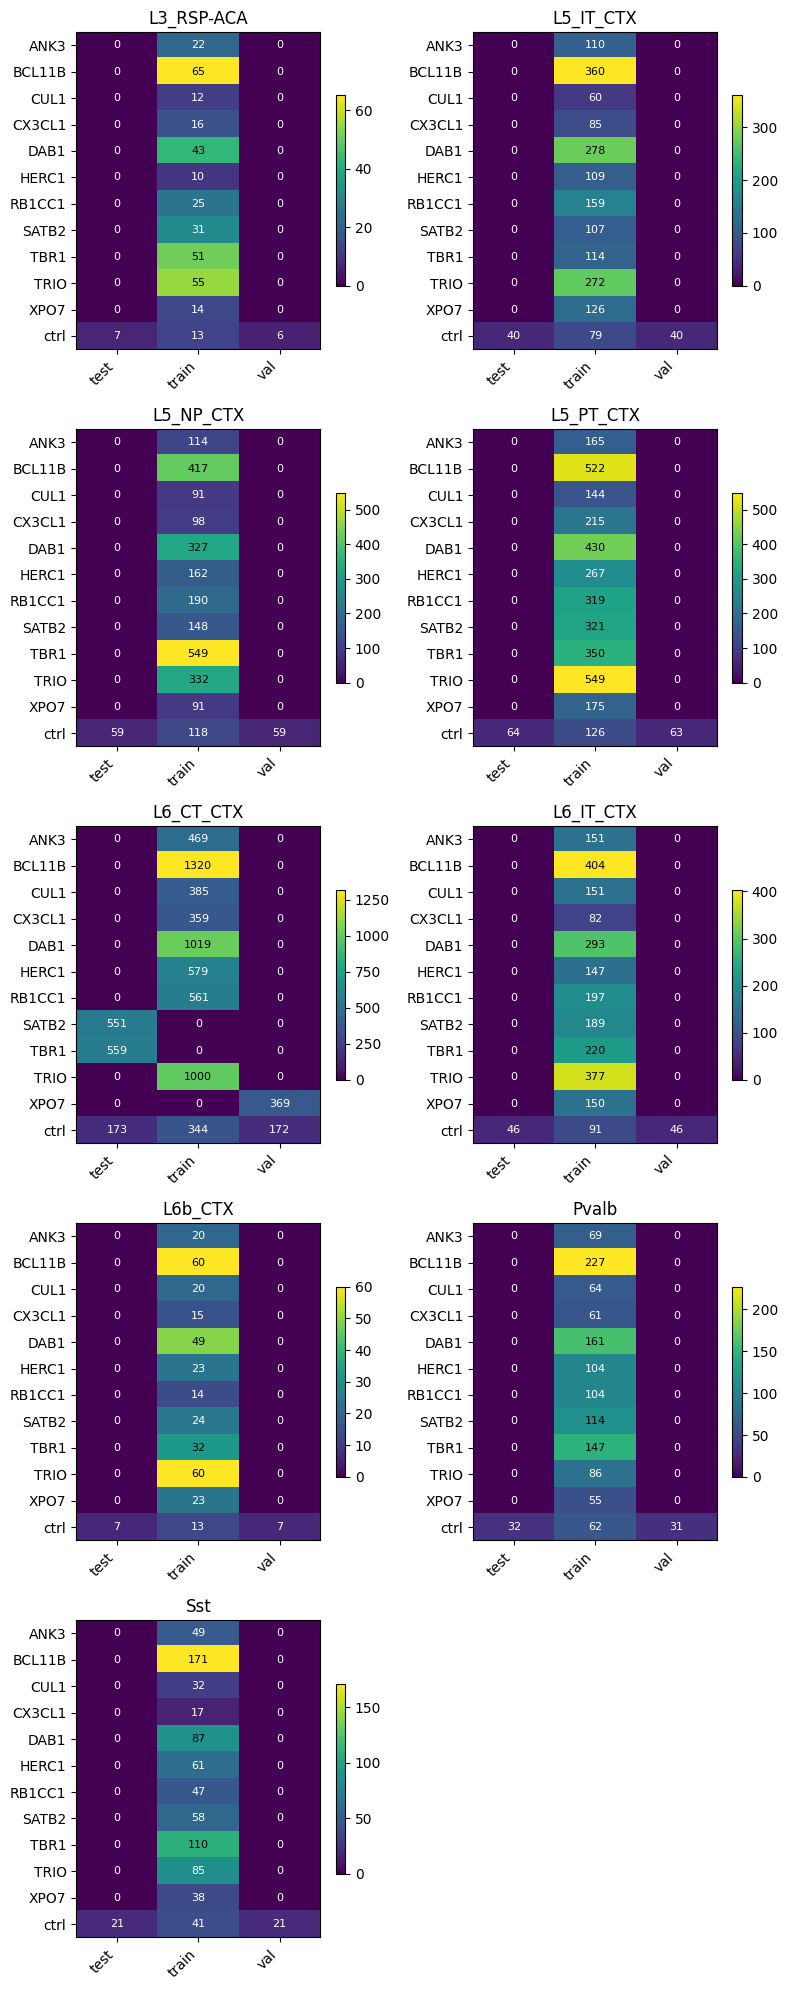

(<Figure size 800x2000 with 18 Axes>,
 array([<Axes: title={'center': 'L3_RSP-ACA'}>,
        <Axes: title={'center': 'L5_IT_CTX'}>,
        <Axes: title={'center': 'L5_NP_CTX'}>,
        <Axes: title={'center': 'L5_PT_CTX'}>,
        <Axes: title={'center': 'L6_CT_CTX'}>,
        <Axes: title={'center': 'L6_IT_CTX'}>,
        <Axes: title={'center': 'L6b_CTX'}>,
        <Axes: title={'center': 'Pvalb'}>, <Axes: title={'center': 'Sst'}>,
        <Axes: >], dtype=object))

In [11]:
plot_counts(boli.obs, cell_line_col="cell_type", gene_col="condition")